In [1]:
import pandas as pd
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import glob

In [2]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [3]:
from src.kube.pod import get_pod_names
from src.prometheus.time_utils import generate_time
from src.prometheus.metrics import metric_labels
from src.prometheus.constants import prometheus_endpoint, prometheus_query, excluding_services

In [4]:
pods = ['vehicles-service', 'customers-service', 'orders-service',
        'availability-service']

In [5]:
files = glob.glob("/home/mfi/Pacco/Pacco.QoSNeuralNetwork/src/scrapped_data/not_scaled/*.csv")
files

['/home/mfi/Pacco/Pacco.QoSNeuralNetwork/src/scrapped_data/not_scaled/1598877404.csv',
 '/home/mfi/Pacco/Pacco.QoSNeuralNetwork/src/scrapped_data/not_scaled/1598399688.csv']

In [6]:
datasets = [pd.read_csv(file) for file in files]
print(len(datasets))

2


In [7]:
dataset = pd.concat(datasets)

min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(dataset)
dataset = pd.DataFrame(x_scaled, columns=dataset.columns)

In [8]:
cols = [c for c in dataset.columns if c.split('_')[-1] in pods]

In [9]:
dataset = dataset[cols]
dataset = dataset.astype('float32')
dataset.shape

(84420, 36)

In [10]:
dataset.head()

,aspnetcore_requests_per_second_sum_vehicles-service,aspnetcore_requests_per_second_sum_customers-service,aspnetcore_requests_per_second_sum_orders-service,aspnetcore_requests_per_second_sum_availability-service,aspnetcore_requests_duration_seconds_vehicles-service,aspnetcore_requests_duration_seconds_customers-service,aspnetcore_requests_duration_seconds_orders-service,aspnetcore_requests_duration_seconds_availability-service,dotnet_gc_pause_ratio_vehicles-service,dotnet_gc_pause_ratio_customers-service,...,application_httprequests_error_rate_total_orders-service,application_httprequests_error_rate_total_availability-service,application_httprequests_transactions_sum_vehicles-service,application_httprequests_transactions_sum_customers-service,application_httprequests_transactions_sum_orders-service,application_httprequests_transactions_sum_availability-service,application_qos_violation_vehicles-service,application_qos_violation_customers-service,application_qos_violation_orders-service,application_qos_violation_availability-service
0,0.0,0.0,0.0,0.0,0.030516,0.004294,0.009826,0.000000,0.260682,0.191816,...,0.0,0.0,0.000323,0.000000,0.000757,0.000024,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.030516,0.010023,0.009826,0.000000,0.291473,0.172283,...,0.0,0.0,0.000328,0.005795,0.000000,0.000374,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.030659,0.010023,0.005021,0.003541,0.370738,0.191816,...,0.0,0.0,0.000637,0.008688,0.006909,0.000523,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.030659,0.021225,0.005021,0.003541,0.415070,0.000000,...,0.0,0.0,0.000721,0.014259,0.008063,0.001258,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.030867,0.021225,0.032765,0.010878,0.370673,0.000000,...,0.0,0.0,0.001821,0.535742,0.033801,0.001621,0.0,0.0,0.0,0.0


In [11]:
batch_size = 420
batches = [(x * batch_size, (x + 1) * batch_size) for x in range(0, int(dataset.shape[0]/batch_size))]

In [12]:
batch_dfs = [dataset.iloc[batch[0]:batch[1]].values for batch in batches]
all_batches = len(batch_dfs)
all_batches

201

In [13]:
X = []
y = []

for idx in range(0, len(pods)):
    X.append([])
    y.append([])
    for b in batch_dfs:
        X[idx].append(b[:, [(len(pods) * x) + idx for x in range(0, 8)]])
        y[idx].append(b[:, [32 + idx]])

In [14]:
y[0][0].shape

(420, 1)

In [15]:
batch_dfs[0].shape

(420, 36)

In [16]:
import random

sample = random.randint(0, all_batches - 1)

In [66]:
y_samples = [random.randint(0, all_batches - 1) for x in range(0, 3)]
y_samples

[77, 81, 176]

In [68]:
y_samples = [83, 81, 159]

/home/mfi/anaconda3/envs/TestTensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  if __name__ == '__main__':


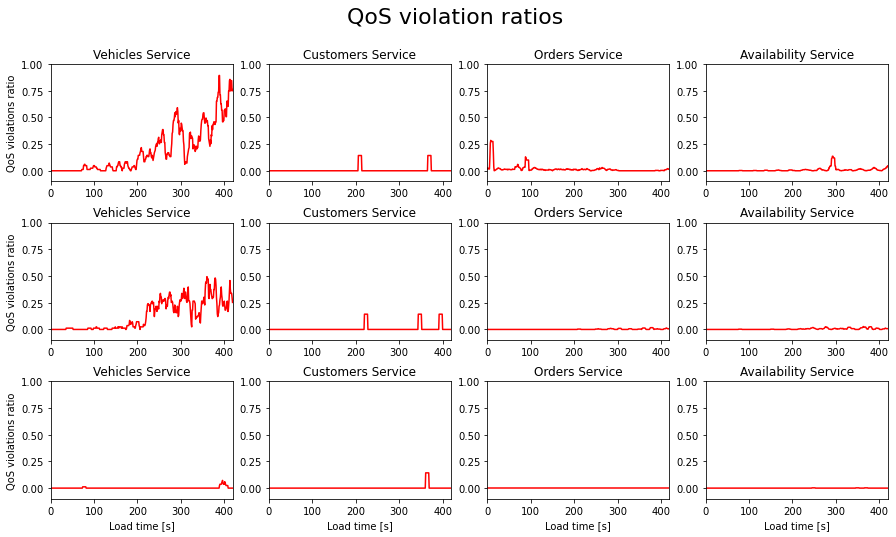

In [119]:
def fancy_service_name(service):
    separated_names = service.split('-')
    for idx, _ in enumerate(separated_names):
        separated_names[idx] = separated_names[idx].capitalize()
    return ' '.join(separated_names)

fig, axs = plt.subplots(len(y_samples), 4, figsize=(15, 8), gridspec_kw={'hspace': 0.35})
fig.suptitle(f'QoS violation ratios', fontsize=22)
fig.tight_layout()
fig.subplots_adjust(top=0.88)
x_ax = np.arange(0, batch_size, 1)
#sample_x = X[sample]
#sample_y = y[sample]

for s_idx, sample in enumerate(y_samples):
    for idx in range(0, len(pods)):
        ax_data = axs[s_idx, idx]

        ax_data.plot(x_ax, y[idx][sample].reshape(-1, 1), color='red')
        ax_data.set_xlim([min(x_ax), max(x_ax)])
        ax_data.set_ylim([-0.1, 1.0])
        
        ax_data.set_title(fancy_service_name(pods[idx]))
        
        if s_idx == len(y_samples) - 1:
            ax_data.set_xlabel("Load time [s]")
        if idx == 0:
            ax_data.set_ylabel("QoS violations ratio")
        
        
plt.savefig('plots/NN/y_data.png')

In [70]:
samples = [83, 81, 159]

/home/mfi/anaconda3/envs/TestTensorflow/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


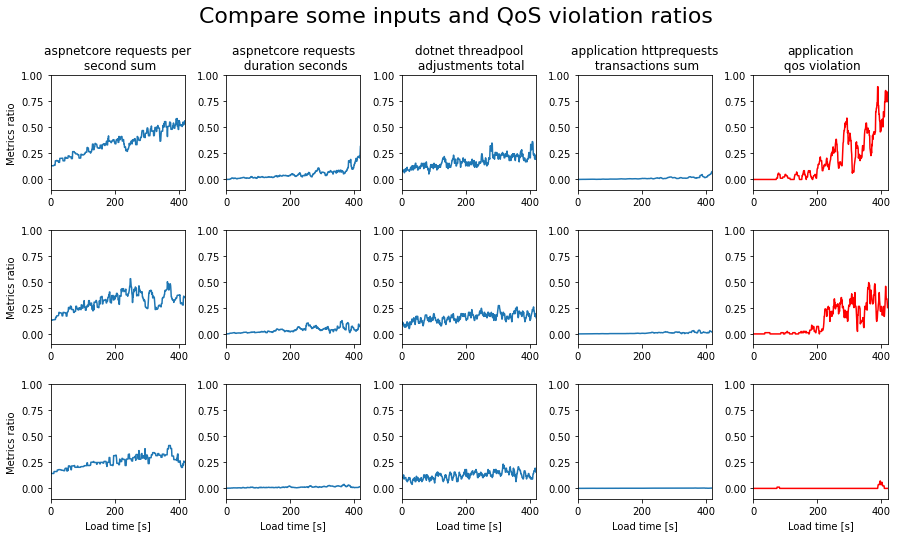

In [121]:
def fancy_metric_name(metric):
    separated_names = metric.split('_')
    separated_names[-4] = separated_names[-4] + '\n'
    return ' '.join(separated_names[:-1])

fig, axs = plt.subplots(len(y_samples), 5, figsize=(15, 8), gridspec_kw={'hspace': 0.35, 'wspace': 0.31})
fig.suptitle(f'Compare some inputs and QoS violation ratios', fontsize=22)
fig.tight_layout()
fig.subplots_adjust(top=0.86)
x_ax = np.arange(0, batch_size, 1)
#sample_x = X[sample]
#sample_y = y[sample]

metrics = [0, 1, 3, 7]
for s_idx, sample in enumerate(y_samples):
    for m_idx, metric in enumerate(metrics):
        ax_data = axs[s_idx, m_idx]

        ax_data.plot(x_ax, X[0][sample][:, metric].reshape(-1, 1))
        ax_data.set_xlim([min(x_ax), max(x_ax)])
        ax_data.set_ylim([-0.1, 1.0])
        
        metric_idx = (4 * metric)
        if s_idx == 0:
            ax_data.set_title(fancy_metric_name(cols[metric_idx]))
        if s_idx == len(y_samples) - 1:
            ax_data.set_xlabel("Load time [s]")
        if m_idx == 0:
            ax_data.set_ylabel("Metrics ratio")
        
for s_idx, sample in enumerate(y_samples):
    ax_data = axs[s_idx, 4]

    ax_data.plot(x_ax, y[0][sample].reshape(-1, 1), color='red')
    ax_data.set_xlim([min(x_ax), max(x_ax)])
    ax_data.set_ylim([-0.1, 1.0])


    if s_idx == 0:
        ax_data.set_title(fancy_metric_name(cols[-1]))
    if s_idx == len(y_samples) - 1:
        ax_data.set_xlabel("Load time [s]")
#plt.savefig('plots/NN/scaled_data.png')

In [55]:
X[0][0].shape

(420, 8)

In [51]:
len(y)

4

In [57]:
X[0][83].shape

(420, 8)

In [60]:
cols

['aspnetcore_requests_per_second_sum_vehicles-service',
 'aspnetcore_requests_per_second_sum_customers-service',
 'aspnetcore_requests_per_second_sum_orders-service',
 'aspnetcore_requests_per_second_sum_availability-service',
 'aspnetcore_requests_duration_seconds_vehicles-service',
 'aspnetcore_requests_duration_seconds_customers-service',
 'aspnetcore_requests_duration_seconds_orders-service',
 'aspnetcore_requests_duration_seconds_availability-service',
 'dotnet_gc_pause_ratio_vehicles-service',
 'dotnet_gc_pause_ratio_customers-service',
 'dotnet_gc_pause_ratio_orders-service',
 'dotnet_gc_pause_ratio_availability-service',
 'dotnet_threadpool_adjustments_total_vehicles-service',
 'dotnet_threadpool_adjustments_total_customers-service',
 'dotnet_threadpool_adjustments_total_orders-service',
 'dotnet_threadpool_adjustments_total_availability-service',
 'dotnet_threadpool_scheduled_total_vehicles-service',
 'dotnet_threadpool_scheduled_total_customers-service',
 'dotnet_threadpool_s